<a href="https://colab.research.google.com/github/pscabral/IFMASOFTEX_1/blob/main/mobilenetv2_3.00_160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import PIL
import glob
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.random import set_seed

In [ ]:
train_path = '../content/train'
val_path = '../content/validation'
test_path = '../content/test'

In [ ]:
data_dicts = {
    'train':[],
    'test':[],
    'val':[]
}
data_labels = {
    'train':[],
    'test':[],
    'val':[]
}

In [ ]:
for phase in ['train','val','test']:
    if phase == 'train':
        data_dir = train_path
    elif phase == 'val':
        data_dir = val_path
    else:
        data_dir = test_path
    class_names = sorted(x for x in os.listdir(data_dir)
                            if os.path.isdir(os.path.join(data_dir, x)))
    num_class = len(class_names)
    image_files = [
        [
            os.path.join(data_dir, class_names[i], x)
            for x in os.listdir(os.path.join(data_dir, class_names[i]))
        ]
        for i in range(num_class)
    ]
    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = []
    image_class = []
    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])
    data_dicts[phase] = image_files_list
    data_labels[phase] = image_class
    num_total = len(image_class)
    image_width, image_height = PIL.Image.open(image_files_list[0]).size
    print(f"{phase} information")
    print(f"Image dimensions: {image_width} x {image_height}")
    print(f"Label names: {class_names}")
    print(f"Label counts: {num_each}")
    print(f"Total image count: {num_total}")
    print('--'*8)

train information
Image dimensions: 2000 x 1000
Label names: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
Label counts: [68, 75, 88, 90, 92, 89, 82, 79, 87, 87, 94, 84, 92, 68, 100, 88, 88, 82, 97, 86, 94, 69, 83, 89, 100, 99, 79, 77, 81, 97, 97, 91, 69, 92, 98, 84]
Total image count: 3115
----------------
val information
Image dimensions: 2000 x 1000
Label names: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pine

In [ ]:
df = pd.DataFrame({'path': data_dicts['train'],'label': data_labels['train']})
sorted_counts  = df.value_counts('label')
fig = px.pie(names=class_names, values=sorted_counts, title="Class Distribution in Trainset", hole=0.3)
fig.show()

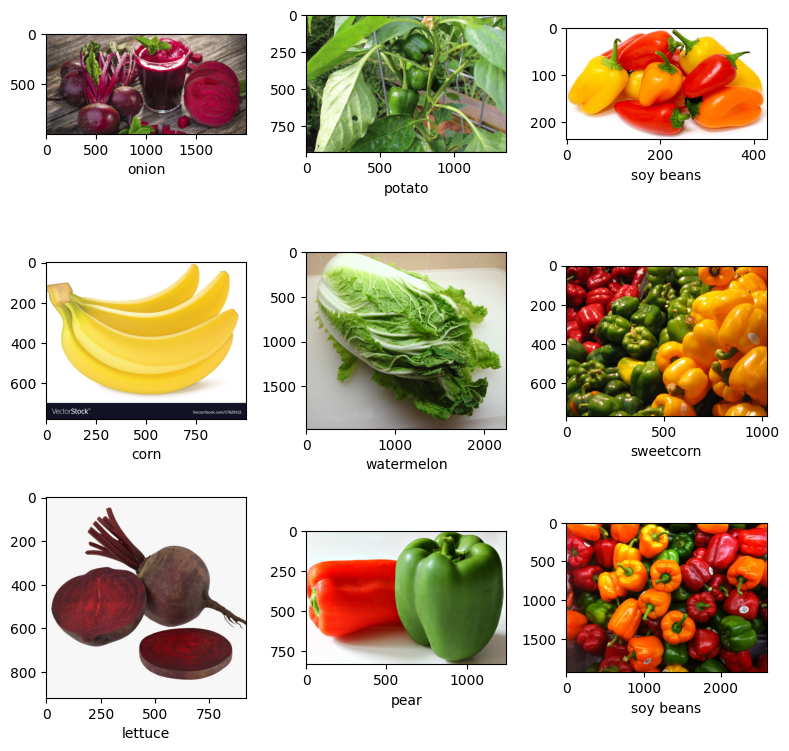

In [ ]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(data_dicts['train'][k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

data_generator = {
    'train': ImageDataGenerator(
        rescale=1/255.0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        rotation_range=10
    ),
    'val': ImageDataGenerator(
        rescale=1/255.0,
        width_shift_range=0.1,
        height_shift_range=0.1
    ),
    'test': ImageDataGenerator(
        rescale=1/255.0
    )
}


In [ ]:
data_sets = {
    'train':data_generator['train'].flow_from_directory(train_path,shuffle=True,class_mode='binary' ,batch_size=batch_size),
    'val':data_generator['val'].flow_from_directory(val_path,shuffle=False,class_mode='binary',batch_size=batch_size),
    'test':data_generator['test'].flow_from_directory(test_path,shuffle=False,class_mode='binary',batch_size=batch_size)
}

Found 3115 images belonging to 36 classes.
Found 351 images belonging to 36 classes.
Found 359 images belonging to 36 classes.


In [ ]:
for i,(images,labels) in enumerate(data_sets['train']):
    print('labels of first batch in trainset:',labels)
    print(labels.shape)
    print(images.shape)
    break

labels of first batch in trainset: [ 1. 25. 12.  5. 33.  9.  9. 35.  3. 16. 33.  7. 22.  7. 30. 18. 16. 14.
 34. 30. 19. 30. 31. 32. 31.  3. 24. 13. 24. 21.  4. 33.]
(32,)
(32, 256, 256, 3)


In [ ]:
def show_images(GRID=[3,3], model=None, size=(8,8), data=data_sets['train']):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows

    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(32)
        image, label = images[id], class_names[int(labels[id])]

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)

        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"

        plt.title(title)
        plt.axis('off')

        i+=1
        if i>=(n_images+1):
            break

    plt.tight_layout()
    plt.show()

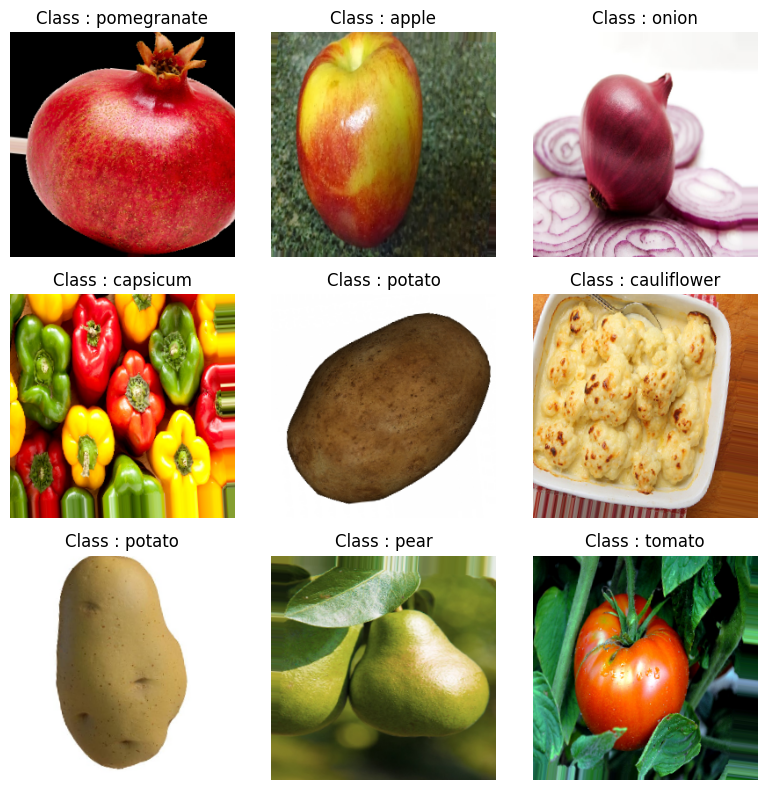

In [ ]:
show_images()

In [ ]:
pretrained = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=[256,256,3], include_top=False,
    classifier_activation='softmax',
)
pretrained.trainable = False
model = tf.keras.models.Sequential([
    pretrained,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(36, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
epochs = 10
history = model.fit(data_sets['train'], validation_data=data_sets['val'],
                             epochs=epochs,callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/10
18/98 [====>.........................] - ETA: 3:09 - loss: 3.0546 - accuracy: 0.2306

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



98/98 [==============================] - 297s 3s/step - loss: 1.6184 - accuracy: 0.5567 - val_loss: 0.5138 - val_accuracy: 0.8405
Epoch 2/10
98/98 [==============================] - 292s 3s/step - loss: 0.6146 - accuracy: 0.8090 - val_loss: 0.4156 - val_accuracy: 0.8832
Epoch 3/10
98/98 [==============================] - 281s 3s/step - loss: 0.4339 - accuracy: 0.8584 - val_loss: 0.3182 - val_accuracy: 0.9003
Epoch 4/10
98/98 [==============================] - 286s 3s/step - loss: 0.3230 - accuracy: 0.8921 - val_loss: 0.2790 - val_accuracy: 0.9202
Epoch 5/10
98/98 [==============================] - ETA: 0s - loss: 0.2576 - accuracy: 0.9098

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



98/98 [==============================] - 284s 3s/step - loss: 0.2576 - accuracy: 0.9098 - val_loss: 0.2526 - val_accuracy: 0.9231
Epoch 6/10
98/98 [==============================] - 286s 3s/step - loss: 0.1947 - accuracy: 0.9326 - val_loss: 0.2528 - val_accuracy: 0.9316
Epoch 7/10
98/98 [==============================] - 290s 3s/step - loss: 0.1719 - accuracy: 0.9361 - val_loss: 0.2386 - val_accuracy: 0.9430
Epoch 8/10
98/98 [==============================] - 284s 3s/step - loss: 0.1452 - accuracy: 0.9493 - val_loss: 0.2167 - val_accuracy: 0.9487
Epoch 9/10
98/98 [==============================] - 285s 3s/step - loss: 0.1122 - accuracy: 0.9599 - val_loss: 0.2108 - val_accuracy: 0.9430
Epoch 10/10
98/98 [==============================] - 276s 3s/step - loss: 0.1071 - accuracy: 0.9644 - val_loss: 0.1651 - val_accuracy: 0.9744


In [ ]:
history_df = pd.DataFrame(history.history)

In [ ]:
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.618435,0.556661,0.513839,0.840456
1,0.614550,0.808989,0.415588,0.883191
2,0.433906,0.858427,0.318228,0.900285
3,0.323022,0.892135,0.279006,0.920228
4,0.257626,0.909791,0.252629,0.923077
5,0.194721,0.932584,0.252762,0.931624
6,0.171935,0.936116,0.238576,0.943020
7,0.145172,0.949278,0.216659,0.948718
8,0.112189,0.959872,0.210823,0.943020
9,0.107129,0.964366,0.165080,0.974359


In [ ]:
line = px.line(data_frame= history_df ,y =["accuracy","val_accuracy"] , markers = True)
line.update_xaxes(title="epochs",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_layout(showlegend = True,
    title = {
        'text': 'train acc Vs. val acc',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
line.show()

In [ ]:
line = px.line(data_frame= history_df ,y =["loss" , "val_loss"] , markers = True)
line.update_xaxes(title="epochs",
              rangeslider_visible = False)
line.update_yaxes(title = "Loss")
line.update_layout(showlegend = True,
    title = {
        'text': 'train loss Vs. val loss',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
line.show()

In [ ]:
model.save('vgg19.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
model_path = './vgg19.h5'
model = load_model(model_path)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 36)                2340      
                                                                 
Total params: 2949028 (11.25 MB)
Trainable params: 691

In [ ]:
score = model.evaluate(data_sets['test'])

12/12 [==============================] - 29s 2s/step - loss: 0.1527 - accuracy: 0.9721


In [ ]:
print('{}:{}'.format(model.metrics_names[1],score[1]*100))
print('{}:{}'.format(model.metrics_names[0],score[0]))

accuracy:97.21448421478271
loss:0.1527116596698761


1/1 [==============================] - 0s 58ms/step


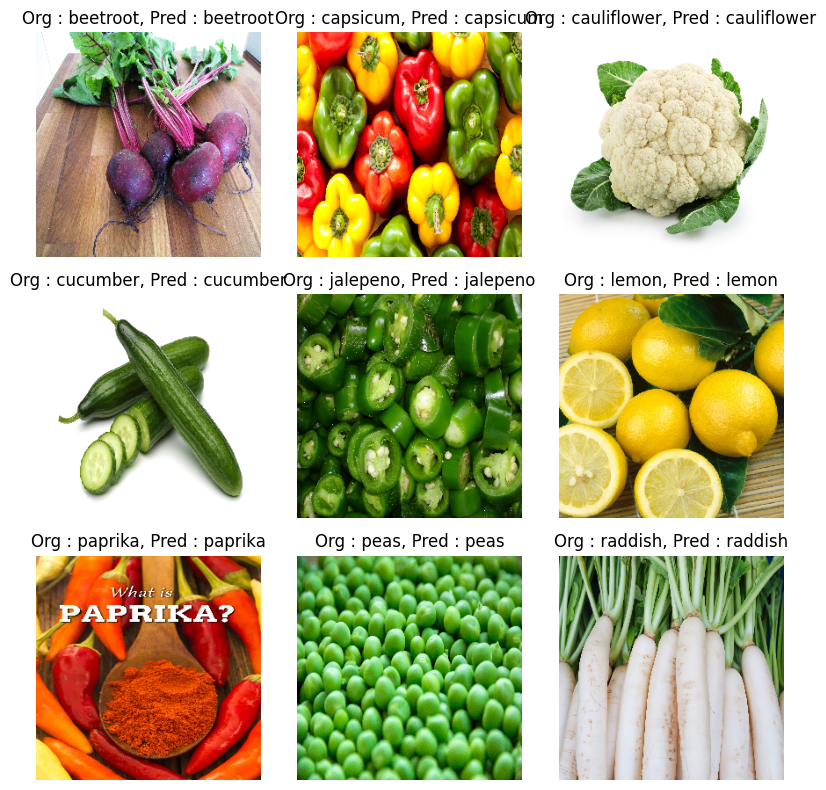

In [ ]:
show_images(model=model, data=data_sets['test'])

In [ ]:
from sklearn.metrics import classification_report
labels_classes = data_sets['test'].classes  # Classes reais do conjunto de teste
pred_probs = model.predict(data_sets['test'])  # Probabilidades previstas para cada classe
pred_classes = np.argmax(pred_probs, axis=1)  # Classes previstas com base nas probabilidades
#print(classification_report(labels_classes, pred_classes))
print(classification_report(labels_classes,pred_classes))

12/12 [==============================] - 28s 2s/step
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00        10
           3       1.00      0.90      0.95        10
           4       1.00      1.00      1.00        10
           5       0.91      1.00      0.95        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       0.82      0.90      0.86        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       0.83      1.00      0.91        10
          16       1.00     

In [ ]:
classes = list(data_sets['test'].class_indices.keys())
real_classes = [classes[x] for x in data_sets['test'].labels]

pred = tf.argmax(model.predict(data_sets['test']),axis=1)
pred_classes = [classes[x] for x in pred]

12/12 [==============================] - 30s 2s/step


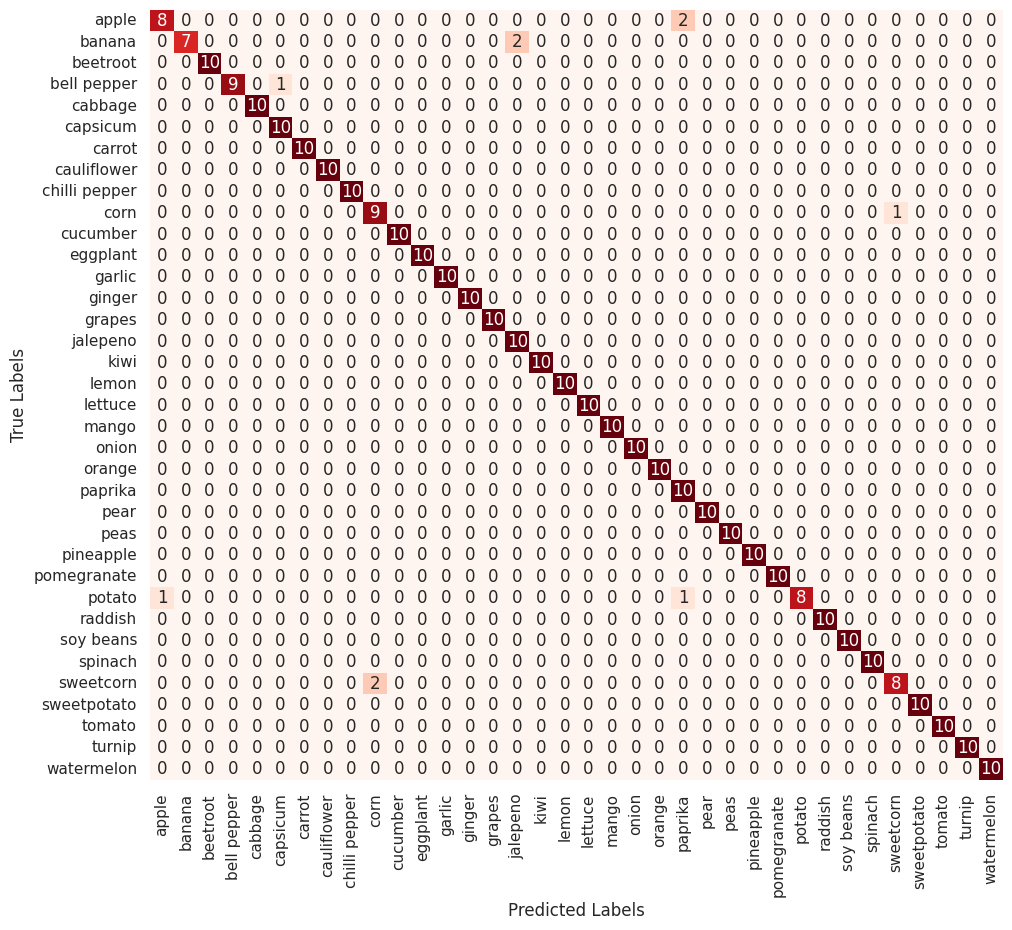

In [ ]:
cf_matrix = metrics.confusion_matrix(real_classes,pred_classes)
sns.set_theme(rc={'figure.figsize':(11,10)})
ax = sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=classes,yticklabels=classes,cbar=False)
ax.set_ylabel('True Labels')
ax.set_xlabel('Predicted Labels');

In [ ]:
 def plot_confusion_matrix(y_true, y_pred, class_names):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    confusion_matrix = confusion_matrix.astype(int)

    layout = {
        "title": "Confusion Matrix",
        "xaxis": {"title": "Predicted value"},
        "yaxis": {"title": "Real value"}
    }

    fig = go.Figure(data=go.Heatmap(z=confusion_matrix,
                                    x=class_names,
                                    y=class_names,
                                    hoverongaps=False,
                                   ),
                    layout=layout)
    fig.show()

In [ ]:
 def plot_confusion_matrix(y_true, y_pred, class_names):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    confusion_matrix = confusion_matrix.astype(int)

    layout = {
        "title": "Confusion Matrix",
        "xaxis": {"title": "Predicted value"},
        "yaxis": {"title": "Real value"}
    }

    fig = go.Figure(data=go.Heatmap(z=confusion_matrix,
                                    x=class_names,
                                    y=class_names,
                                    hoverongaps=False,
                                   ),
                    layout=layout)
    fig.show()

In [ ]:
plot_confusion_matrix(real_classes,pred_classes,classes)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np

# Carregue o modelo MobileNetV2 treinado
model = MobileNetV2(weights='imagenet')

# Carregue e pré-processe a imagem de entrada
img_path = '/content/validation/corn/Image_2.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Ajuste o tamanho da imagem de acordo com o MobileNetV2
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Faça a inferência
predictions = model.predict(x)

# Decodifique as previsões
decoded_predictions = decode_predictions(predictions, top=5)[0]

# Imprima as previsões
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")

1/1 [==============================] - 1s 869ms/step
1: ear (0.50)
2: corn (0.09)
3: zucchini (0.01)
4: yellow_lady's_slipper (0.01)
5: jackfruit (0.01)
